# <span style="color:orange"> Laboratorio di Simulazione Numerica </span>
## <span style="color:orange"> Esercitazione 4 </span>

### Paolo Panatti (12606A)

### <font color="blue"> Esercizio 04.1

#### Obiettivo:
Includere nel codice NSL_SIMULATOR il calcolo della distribuzione dei moduli delle velocità $p(v^*,T^*)$.

#### Distribuzione di Maxwell-Boltzmann
In Meccanica Statistica la distribuzione di Maxwell-Boltzmann è una distribuzione di probabilità che descrive le velocità delle particelle in un gas ideale. Essa inoltre costituisce un'ottima approssimazione nel caso di gas reali rarefatti a temperature ordinarie, che hanno un comportamento molto simile a quello di un gas ideale. Per un sistema in 3D la sua espressione è:
$$p(v,T) = \left( \frac{m}{2\pi k_B T} \right)^{3/2} 4\pi v^2 e^{-\frac{m v^2}{2 k_B T}}$$
Nelle unità ridotte di LJ (Lunghezza: $\sigma$, Energia: $\epsilon$, Massa: massa $m$ delle particelle, Temperatura: $\epsilon/k_B$, Velocità: $\sqrt{\epsilon/m}$) diventa:
$$p(v^*,T^*) = \frac{1}{(2\pi T^*)^{3/2}} 4\pi (v^*)^2 e^{-\frac{(v^*)^2}{2 T^*}}$$

L'esercizio chiedeva di implementare il calcolo della distribuzione utilizzando come al solito il metodo data blocking per ottenere valori medi di blocco, valori medi progressivi e incertezze progressive. Per farlo ho costruito un istogramma normalizzato suddividendo l'intervallo $\left[0,v_{max}\right]$ in $30$ bin e incrementando un certo contatore ogniqualvolta la velocità di una particella cade all'interno del bin corrispondente. La velocità massima è fissata a $4\sqrt{T^*}$ in unità ridotte, in modo da includere quasi tutta l'area sotto la curva. Riporto qui sotto i frammenti di codice commentati.

```c++
if (_measure_pofv){
    for (int i = 0; i < _npart; i++){
        double velocity = sqrt(dot(_particle[i].getvelocity(),_particle[i].getvelocity()));  // modulo della velocità
        if (velocity < _n_bins_v*_bin_size_v){  // controllo che la velocità non sia fuori range
            bin = int(velocity/_bin_size_v);    // identifico il bin
            counts++;                           // incremento i conteggi totali
            bin_counts[bin]++;                  // incremento il contatore del bin
        }
    }
    double norm = 1.0/(double(counts)*_bin_size_v);  // fattore di normalizzazione
    for (int i = 0; i < _n_bins_v; i++){
        _measurement(_index_pofv + i) = bin_counts[i]*norm;  // normalizzo e memorizzo
    }
}
```

```c++
if (_measure_pofv){
    coutf.open("../OUTPUT/pofv.dat",ios::app);
    for (int i = 0; i < _n_bins_v; i++){
        double velocity = (i + 0.5) * _bin_size_v;     // centro del bin
        average  = _average(_index_pofv + i);          // valor medio di blocco
        sum_average = _global_av(_index_pofv + i);     // somma delle medie dei blocchi
        sum_ave2 = _global_av2(_index_pofv + i);       // somma dei quadrati delle medie
        coutf << setw(12) << velocity
              << setw(15) << average
              << setw(12) << sum_average/double(blk)                            // media cumulativa
              << setw(12) << this->error(sum_average, sum_ave2, blk) << endl;   // incertezza statistica
    }
    coutf << endl << endl;
    coutf.close();
}
```

### <font color="blue"> Esercizio 04.2

#### Obiettivo:
Eseguire una simulazione di dinamica molecolare (MD) con un modello Lennard-Jones per una fase gassosa partendo da una configurazione iniziale a bassa entropia e mostrare che il sistema evolve verso una configurazione di equilibrio con entropia maggiore.

I parametri della simulazione sono i seguenti: $\rho^* = 0.05$, $T^* \sim 2.0$ e $r_c = 5.0$ (raggio di cut-off del potenziale).

All'istante iniziale le $108$ particelle sono disposte a formare un reticolo fcc (cubico a facce centrate) che occupa metà del box di simulazione in ogni dimensione e ciascuna di esse ha velocità $\pm v_{T^*}$, legata alla temperatura $T^*$ in modo adeguato, lungo una sola delle tre direzioni $x$, $y$ e $z$. La distribuzione iniziale delle velocità è dunque una delta di Dirac: $p_\delta(v^*,T^*) = \delta\left(v^* - v_{T^*}\right)$.

Per questa simulazione, in particolare, ho utilizzato $20$ blocchi da $2000$ passi ciascuno.

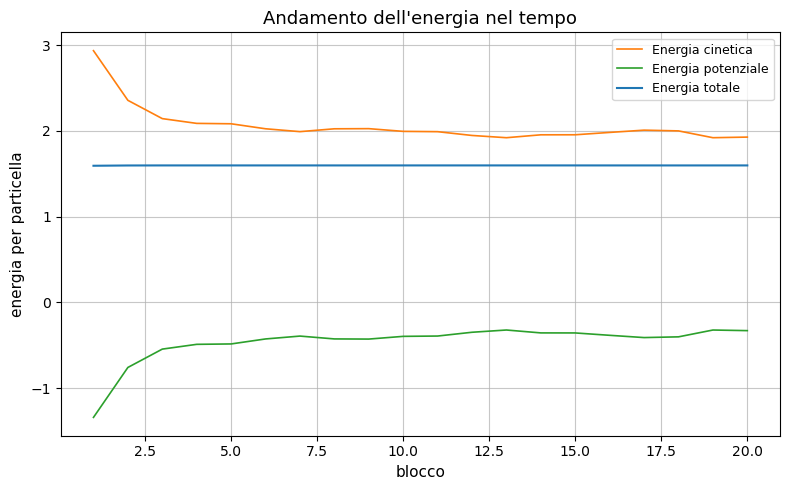

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

blocks, kenergy = np.loadtxt("Es2/OUTPUT/kinetic_energy.dat", usecols=(0,1), unpack='true')
penergy = np.loadtxt("Es2/OUTPUT/potential_energy.dat", usecols=1, unpack='true')
tenergy = np.loadtxt("Es2/OUTPUT/total_energy.dat", usecols=1, unpack='true')

plt.figure(figsize=(8, 5))

plt.plot(blocks, kenergy, color='tab:orange', linewidth=1.2, label='Energia cinetica')
plt.plot(blocks, penergy, color='tab:green', linewidth=1.2, label='Energia potenziale')
plt.plot(blocks, tenergy, color='tab:blue', linewidth=1.5, label='Energia totale')
plt.xlabel('blocco', fontsize=11)
plt.ylabel('energia per particella', fontsize=11)
plt.title("Andamento dell'energia nel tempo", fontsize=13)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.7)

plt.tight_layout()
plt.show()

In una simulazione di dinamica molecolare l'energia totale del sistema è conservata (*ensamble microcanonico*), di conseguenza energia cinetica e temperatura non sono costanti del moto ma possono variare. Il grafico in alto mostra l'evoluzione temporale delle diverse componenti energetiche per particella: come previsto, l'energia totale rimane costante, mentre i contributi cinetico e potenziale rispettivamente diminuiscono e crescono fino a stabilizzarsi attorno ad un certo valore, in corrispondenza del raggiungimento della configurazione di equilibrio, caratterizzata da maggiore entropia. Con l'energia cinetica diminuisce anche la temperatura, che raggiunge un valore finale di circa $1.3$.

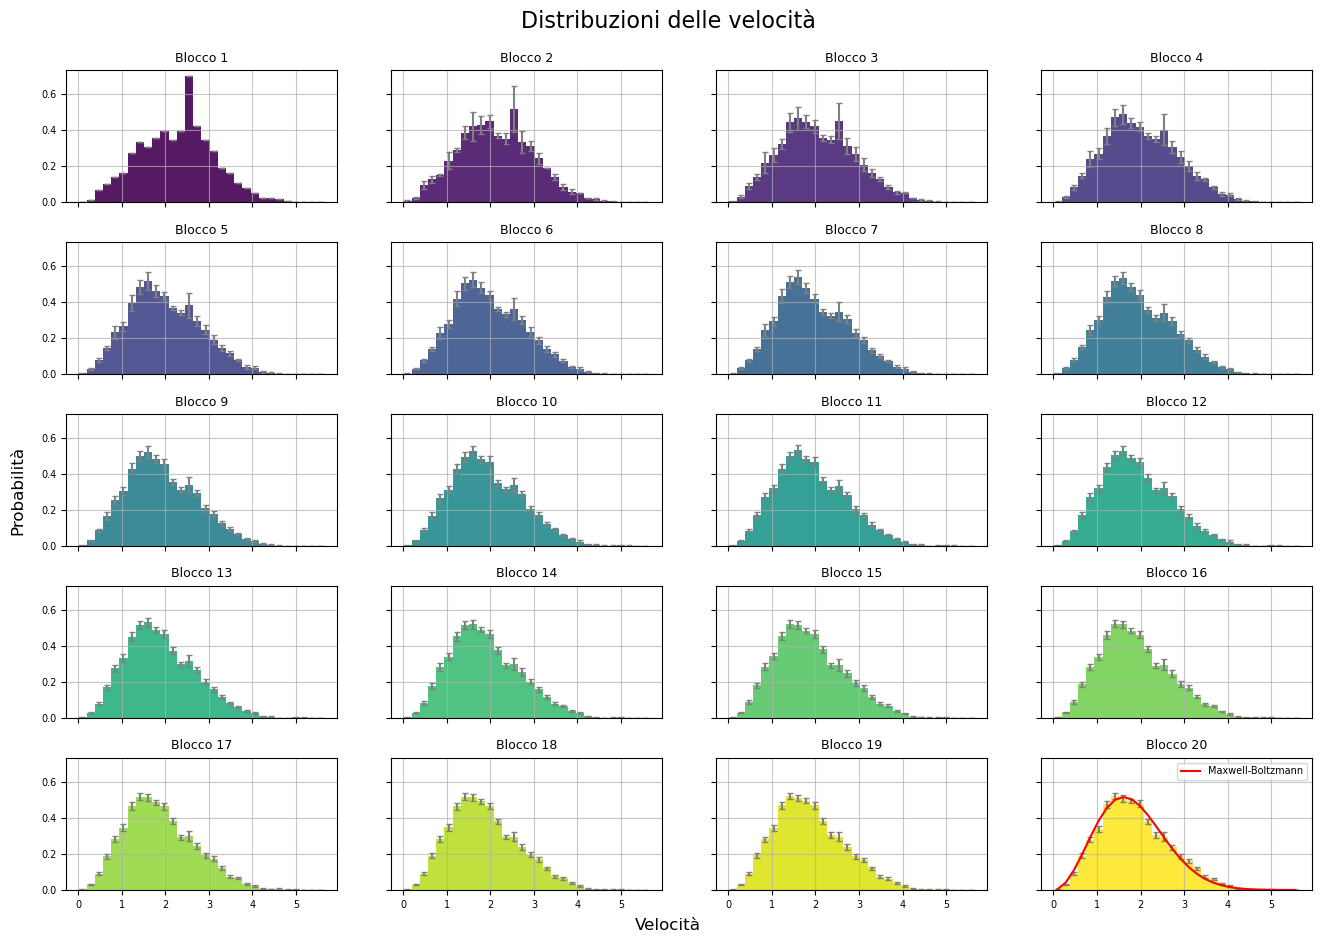

In [64]:
import matplotlib.cm as cm

data = np.loadtxt("Es2/OUTPUT/pofv.dat")

velocity = data[:30, 0]
pofv_values = data[:, 2].reshape((20, 30))
pofv_errors = data[:, 3].reshape((20, 30))

T = 1.3

def maxwell_boltzmann(v, T):
    return 1/(2*np.pi*T)**(3.0/2.0) * 4 * np.pi * v**2 * np.exp(-v**2/(2*T))

fig, axs = plt.subplots(5, 4, figsize=(14, 10), sharex=True, sharey=True)
axs = axs.flatten()

colors = cm.viridis(np.linspace(0, 1, 20))

for i in range(20):
    axs[i].bar(
        velocity,
        pofv_values[i],
        yerr=pofv_errors[i],
        width=velocity[1] - velocity[0],
        color=colors[i],
        alpha=0.9,
        capsize=2,
        ecolor='grey'
    )
    if i == 19:
        axs[i].plot(velocity, maxwell_boltzmann(velocity,T), 'r-', linewidth=1.5, label='Maxwell-Boltzmann')
        axs[i].legend(fontsize=7)
    axs[i].set_title(f'Blocco {i+1}', fontsize=9)
    axs[i].tick_params(axis='both', labelsize=7)
    axs[i].grid(True, alpha=0.7)

plt.subplots_adjust(left=0.07, right=0.96, top=0.92, bottom=0.10, hspace=0.3, wspace=0.2)

fig.suptitle('Distribuzioni delle velocità', fontsize=16, y=0.98)
fig.text(0.5, 0.06, 'Velocità', ha='center', fontsize=12)
fig.text(0.03, 0.5, 'Probabilità', va='center', rotation='vertical', fontsize=12)

plt.show()

Da questi istogrammi, invece, possiamo osservare come la distribuzione delle velocità, inizialmente una delta di Dirac, tenda ad approssimare sempre meglio la distribuzione di Maxwell-Boltzmann, tipica dei gas ideali. Capiamo quindi che le particelle abbandonano progressivamente la configurazione cristallina iniziale disponendosi in modo più disordinato fino a raggiungere una configurazione di equilibrio simile a quella di un gas ideale. L'evoluzione temporale del sistema procede verso un aumento dell'entropia, in accordo con il secondo principio della termodinamica.

### <font color="blue"> Esercizio 04.3

#### Obiettivo:
Vedere cosa succede se, partendo dalla configurazione finale del sistema dell'esercizio precedente, si inverte la direzione del tempo.

Per fare ciò ho fatto ripartire la simulazione scambiando il contenuto dei due file `config.xyz` e `conf-1.xyz` (in modo da invertire le velocità finali) e impostando la temperatura a $1.3$, valore raggiunto alla fine della simulazione precedente. Ho mantenuto anche lo stesso numero di blocchi e di passi per blocco.

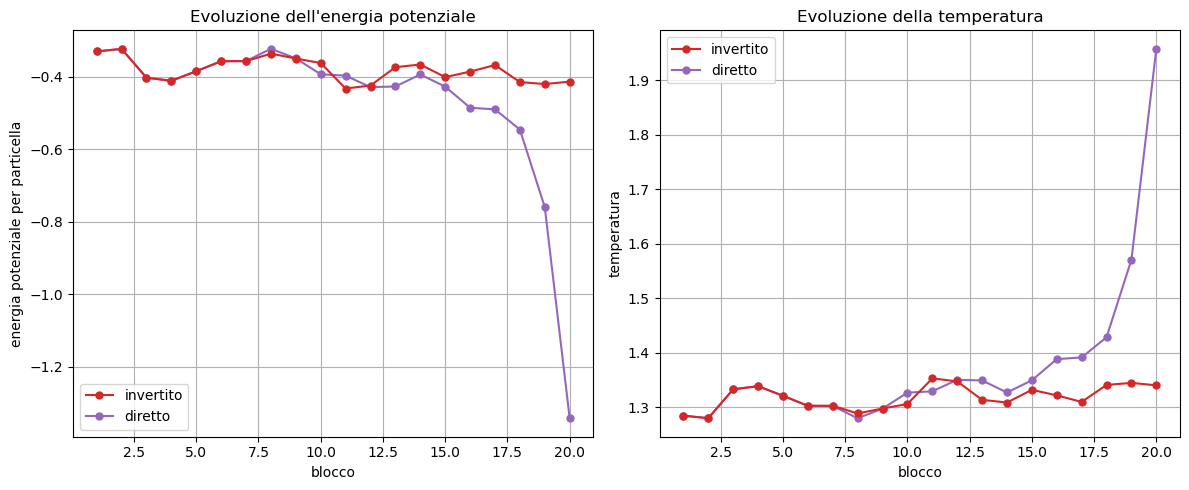

In [93]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

blocks, penergy_inv = np.loadtxt("Es3/OUTPUT/potential_energy.dat", usecols=(0,1), unpack='true')
temp_inv = np.loadtxt("Es3/OUTPUT/temperature.dat", usecols=1, unpack='true')

penergy = np.loadtxt("Es2/OUTPUT/potential_energy.dat", usecols=1, unpack='true')
temp = np.loadtxt("Es2/OUTPUT/temperature.dat", usecols=1, unpack='true')
penergy = penergy[::-1]
temp = temp[::-1]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(blocks, penergy_inv, color='tab:red', marker='o', markersize=5, label='invertito', zorder=2)
axs[0].plot(blocks, penergy, color='tab:purple', marker='o', markersize=5, label='diretto', zorder=1)
axs[0].set_xlabel('blocco')
axs[0].set_ylabel('energia potenziale per particella')
axs[0].set_title("Evoluzione dell'energia potenziale")
axs[0].legend()
axs[0].set_axisbelow(True)
axs[0].grid(True, zorder=0)

axs[1].plot(blocks, temp_inv, color='tab:red', marker='o', markersize=5, label='invertito', zorder=2)
axs[1].plot(blocks, temp, color='tab:purple', marker='o', markersize=5, label='diretto', zorder=1)
axs[1].set_xlabel('blocco')
axs[1].set_ylabel('temperatura')
axs[1].set_title("Evoluzione della temperatura")
axs[1].legend()
axs[1].set_axisbelow(True)
axs[1].grid(True, zorder=0)

plt.tight_layout()
plt.show()

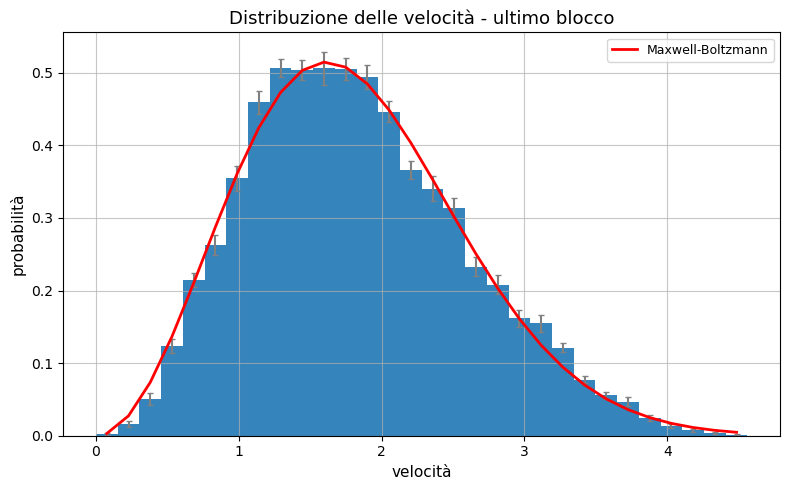

In [107]:
data = np.loadtxt("Es3/OUTPUT/pofv.dat")

velocity = data[:30, 0]
pofv_values_inv = data[:, 2].reshape((20, 30))
pofv_errors_inv = data[:, 3].reshape((20, 30))

T = 1.3

def maxwell_boltzmann(v, T):
    return 1/(2*np.pi*T)**(3.0/2.0) * 4 * np.pi * v**2 * np.exp(-v**2/(2*T))

plt.figure(figsize=(8, 5))

plt.bar(
        velocity,
        pofv_values_inv[-1],
        yerr=pofv_errors_inv[-1],
        width=velocity[1] - velocity[0],
        alpha=0.9,
        capsize=2,
        ecolor='grey'
)
plt.plot(velocity, maxwell_boltzmann(velocity,T), 'r-', linewidth=2, label='Maxwell-Boltzmann')
plt.xlabel('velocità', fontsize=11)
plt.ylabel('probabilità', fontsize=11)
plt.title("Distribuzione delle velocità - ultimo blocco", fontsize=13)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.7)

plt.tight_layout()
plt.show()

Dai vari grafici si osserva chiaramente che il sistema non ritorna alla configurazione iniziale con bassa entropia, ma mantiene un comportamento stabile. Nonostante l'algoritmo di Verlet, con cui vengono integrate le equazioni del moto, sia formalmente simmetrico nel tempo e quindi reversibile, la simulazione ripercorre gli stessi passi di quella precedente soltanto in un primo momento e dopo qualche blocco comincia a deviare. Questa deviazione è dovuta al fatto che l'algoritmo non è numericamente perfetto: nella pratica, errori numerici accumulati, approssimazioni finite ed effetti caotici fanno sì che il sistema si allontani progressivamente dalla traiettoria esatta. Qualsiasi piccola perturbazione, infatti, cresce esponenzialmente con il tempo e di conseguenza porta la traiettoria a divergere da quella esatta (instabilità di Lyapunov). Nessun algoritmo di integrazione è in grado di fornire una soluzione sostanzialmente esatta per un tempo molto lungo. Alla fine della simulazione, perciò, come si evince dalla distribuzione delle velocità che è con buona approssimazione una Maxwell-Boltzmann, il sistema raggiunge una nuova configurazione di equilibrio, ben lontana dalla configurazione cristallina iniziale.